In [1]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://archive.apache.org/dist/spark/spark-3.1.1/spark-3.1.1-bin-hadoop3.2.tgz
!tar xf spark-3.1.1-bin-hadoop3.2.tgz
!pip install -q findspark

In [2]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.1-bin-hadoop3.2"

In [3]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline

In [4]:
spark = SparkSession.builder.master("local[*]").appName("BigDataProject").getOrCreate()

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
df_train = spark.read.csv("/content/drive/My Drive/Big Data/train.csv", header=True, inferSchema=True)

In [8]:
df_train.head(5)

[Row(TITLE='Pete The Cat Bedtime Blues Doll\\', DESCRIPTION=' 14.5 Inch', BULLET_POINTS='Pete the Cat is the coolest\\', BRAND=" most popular cat in town. The new Pete the Cat Bedtime Blues Doll from MerryMakers rocks his striped pj's and red slippers. He is one sleepy cat and is ready to cuddle. Measures 14.5 inches tall. Safe for all ages. Removable clothing. Surface wash only. New 2015", BROWSE_NODE_ID='[Pete the Cat Bedtime Blues plush doll\\'),
 Row(TITLE='The New Yorker NYHM014 Refrigerator Magnet\\', DESCRIPTION=' 2 x 3.5', BULLET_POINTS='The New Yorker Handsome Cello Wrapped Hard Magnet measures 2.5-Inch width by 3.5-Inch height and highlight one of the many beautiful New Yorker covers in full color. Cat In A Tea Cup by New Yorker cover artist Gurbuz Dogan Eksioglu', BRAND='[Cat In A Tea Cup by New Yorker cover artist Gurbuz Dogan Eksioglu\\', BROWSE_NODE_ID='Handsome cello wrapped hard magnet\\'),
 Row(TITLE='The Ultimate Self-Sufficiency Handbook: A Complete Guide to Baking\\

In [9]:
num_rows = df_train.count()
print("Number of Rows:", num_rows)

num_columns = len(df_train.columns)
print("Number of Columns:", num_columns)

Number of Rows: 2903024
Number of Columns: 5


In [10]:
df_train = df_train.dropna()

In [11]:
num_rows = df_train.count()
print("Number of Rows after drop null values:", num_rows)

Number of Rows after drop null values: 2145102


In [12]:
df_train = df_train.dropDuplicates()

In [13]:
num_rows = df_train.count()
print("Number of Rows after drop duplicated rows:", num_rows)

Number of Rows after drop duplicated rows: 2047316


In [ ]:
from pyspark.ml.feature import Tokenizer, HashingTF, StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [ ]:
fraction_to_sample = 0.2
df_train_sampled = df_train.sample(withReplacement=False, fraction=fraction_to_sample, seed=42)
df_train_sampled = df_train_sampled.repartition(5)

In [ ]:
train_ratio = 0.8
test_ratio = 1.0 - train_ratio
train_df, test_df = df_train_sampled.randomSplit([train_ratio, test_ratio], seed=42)

In [ ]:
tokenizer = Tokenizer(inputCol="TITLE", outputCol="title_tokens")
hashing_tf = HashingTF(inputCol="title_tokens", outputCol="title_features", numFeatures=256)

tokenizer_desc = Tokenizer(inputCol="DESCRIPTION", outputCol="desc_tokens")
hashing_tf_desc = HashingTF(inputCol="desc_tokens", outputCol="desc_features", numFeatures=256)

tokenizer_bp = Tokenizer(inputCol="BULLET_POINTS", outputCol="bp_tokens")
hashing_tf_bp = HashingTF(inputCol="bp_tokens", outputCol="bp_features", numFeatures=256)

brand_indexer = StringIndexer(inputCol="BRAND", outputCol="BRAND_index")
encoder = OneHotEncoder(inputCols=["BRAND_index"], outputCols=["BRAND_onehot"])

In [ ]:
label_indexer = StringIndexer(inputCol="BROWSE_NODE_ID", outputCol="label")

In [ ]:
assembler = VectorAssembler(inputCols=["BRAND_onehot", "title_features", "desc_features", "bp_features"], outputCol="features")

In [ ]:
dt = DecisionTreeClassifier(labelCol="label", featuresCol="features")

In [ ]:
pipeline = Pipeline(stages=[tokenizer, hashing_tf, tokenizer_desc, hashing_tf_desc, tokenizer_bp, hashing_tf_bp, brand_indexer, encoder, label_indexer, assembler, dt])

In [ ]:
model = pipeline.fit(df_train_sampled)
predictions = model.transform(test_df)

In [ ]:
X_test = predictions.select("features").rdd.map(lambda row: row.features.toArray()).collect()
y_test = predictions.select("label").rdd.map(lambda row: row.label).collect()


In [ ]:
train_predictions = model.transform(train_df)
X_train = train_predictions.select("features").rdd.map(lambda row: row.features.toArray()).collect()
y_train = train_predictions.select("label").rdd.map(lambda row: row.label).collect()

In [ ]:
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)

In [ ]:
print("Accuracy: {:.2%}".format(accuracy))

Accuracy: 0.9255813953488372


avg_precision: 0.939250039304607   avg_recall: 0.9272080343160257    avg_f1_score: 0.929245199130434


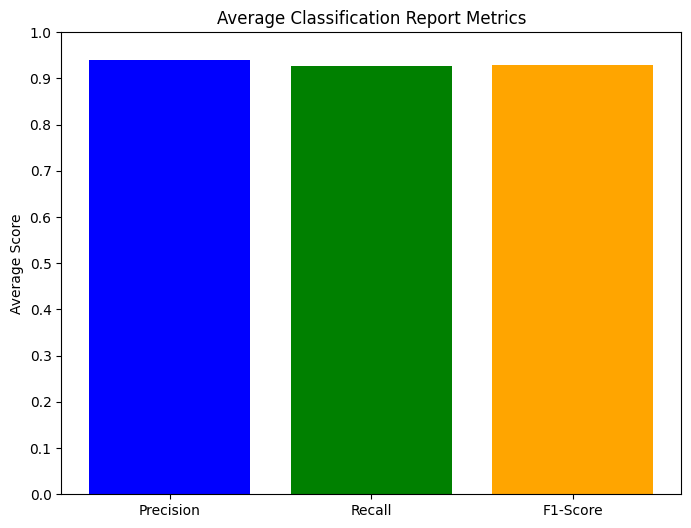

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import numpy as np
import warnings
from sklearn.exceptions import UndefinedMetricWarning

warnings.filterwarnings("ignore", category=UndefinedMetricWarning)
report = classification_report(y_test, predictions, output_dict=True)

precision = [report[class_name]['precision'] if isinstance(report[class_name], dict) else 0.0 for class_name in report.keys()]
recall = [report[class_name]['recall'] if isinstance(report[class_name], dict) else 0.0 for class_name in report.keys()]
f1_score = [report[class_name]['f1-score'] if isinstance(report[class_name], dict) else 0.0 for class_name in report.keys()]

avg_precision = np.mean(precision)
avg_recall = np.mean(recall)
avg_f1_score = np.mean(f1_score)

fig, ax = plt.subplots(figsize=(8, 6))
metrics = ['Precision', 'Recall', 'F1-Score']
values = [avg_precision, avg_recall, avg_f1_score]
print('avg_precision:',avg_precision,'  avg_recall:', avg_recall,'   avg_f1_score:',avg_f1_score)
ax.bar(metrics, values, color=['blue', 'green', 'orange'])
ax.set_ylabel('Average Score')
ax.set_title('Average Classification Report Metrics')

ax.set_yticks(np.arange(0, 1.1, 0.1))
ax.set_ylim(0, 1)

plt.show()